Predicting recurrence of thyroid cancer

### 1. Introduction

<span style="font-size:14px">

Background: Thyroid cancer is one of the most common endocrine malignancies, with a generally favorable prognosis but a non-negligible risk of recurrence. Understanding the epidemiology and recurrence patterns is crucial for guiding clinical decision-making and long-term patient management. Traditional statistical methods have been widely applied to evaluate associations between clinical and demographic predictors and thyroid cancer recurrence, providing valuable but sometimes limited insights.

Purpose: The present project explores recurrence in thyroid cancer patients using both classical and modern analytic techniques. Initially, we applied conventional logistic regression to examine associations between several predictors and recurrence. We then transitioned to machine learning approaches for risk stratification and assess predictive performance, testing scenarios with and without correlated features. This dual strategy allows for both interpretability through statistical models and predictive optimization through machine learning techniques.

Data Source: The dataset consists of a prospective cohort of 383 thyroid cancer patients who were followed for a minimum duration of 10 years to evaluate recurrence outcomes. While the study is longitudinal in design, it does not provide precise time-to-event information. Consequently, survival models such as Cox regression were not applicable, and we instead focused on binary recurrence outcomes.

Disclaimer: This project does not aim to replicate the original study by Borzooei et al. Rather, it demonstrates alternative analytic strategies for examining the same problem. Given these differences in methodological choices and assumptions, results were not expected to mirror those of the original study.

### 2. Loading libraries and data

 #### 2.1 Import libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
from collections import OrderedDict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # Visualizing missing data
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px


# Statistics & Modeling
import scipy.stats as stats
from scipy.stats import chi2_contingency, kruskal
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Machine Learning - scikit-learn Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix
)
# Jupyter Notebook display settings
from IPython.core.display import display, HTML

# Other analytical tools
from tableone import TableOne
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# External data sources
import requests
from census import Census
from us import states

# Custom utilities
import utils

# Suppress warnings
warnings.filterwarnings("ignore")

C:\Users\nanaw\AppData\Local\Temp\ipykernel_29376\4156261965.py:37: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


#### 2.1 Import dataset

In [2]:
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
differentiated_thyroid_cancer_recurrence = fetch_ucirepo(id=915) 
# data (as pandas dataframes) 
X = differentiated_thyroid_cancer_recurrence.data.features 
y = differentiated_thyroid_cancer_recurrence.data.targets 
  
# metadata 
# print(differentiated_thyroid_cancer_recurrence.metadata) 
# variable information 
# print(differentiated_thyroid_cancer_recurrence.variables) 
# combine X and y into a single dataframe
tcr_raw = pd.concat([X, y], axis=1)

### 3. Data Exploration

#### 3.1 Overview of the data

In [3]:
tcr_raw.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [4]:
print(tcr_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

<span style="font-size:14px">
We have 17 variables and 383 observations. We do not have any missing values


<span style="font-size:14px">
Variables description (confer Borzooei et al. European Archives of Oto-Rhino-Laryngology (2024) 281:2095–2104
https://doi.org/10.1007/s00405-023-08299-w)


Demographics & History

- Age at diagnosis (in years)

- Biological sex (Female, Male)

- Current smoking status

- Past smoking history

- History of radiation therapy to head and neck region

Thyroid Characteristics

- Thyroid function
       Categories: euthyroid, clinical/subclinical hypothyroidism or hyperthyroidism

- Presence of goiter

     Categories: diffuse, single nodular (left/right lobe), multinodular, normal

Physical Exam Findings

- Presence of adenopathy on physical exam

   Categories: no adenopathy, anterior right, anterior left, bilateral, posterior, extensive (all locations)

Cancer Pathology

- Pathological subtype of cancer

    Categories: papillary, micropapillary, follicular, Hürthle cell

- Focality

    Categories: unifocal, multifocal

Staging & Risk

- ATA risk assessment

    Categories: low, intermediate, high

- TNM staging

Includes:

T score (Tumor size/local invasion)

N score (Lymph node involvement)

M score (Distant metastasis)

Final stage

Treatment & Outcome

- Initial treatment response

    Categories: excellent, biochemical incomplete, structurally incomplete, indeterminate

- Recurrence status

    Includes: locoregional recurrence, distant metastasis

### 3.2 Unvariate data exploration

- continouous variables

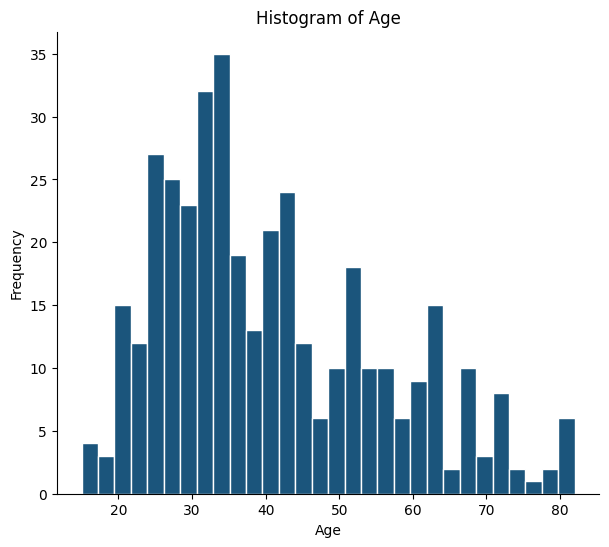

In [5]:
plt.figure(figsize=(7, 6))
plt.hist(tcr_raw["Age"], bins=30, color="#1b557c", edgecolor="white")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Age")
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


In [6]:
tcr_raw["Age"].describe().round(2)

count    383.00
mean      40.87
std       15.13
min       15.00
25%       29.00
50%       37.00
75%       51.00
max       82.00
Name: Age, dtype: float64

Age ranges from 15 to 82 with a mean of 40.87 and a median of 37 (std=15.13, IQR=22)

In [7]:
from scipy.stats import skew, kurtosis

skew_age = skew(tcr_raw["Age"], nan_policy="omit").round(2)
kurt_age = kurtosis(tcr_raw["Age"], nan_policy="omit").round(2)

print("Skewness:", skew_age)
print("Kurtosis:", kurt_age)


Skewness: 0.72
Kurtosis: -0.28


Age variable is moderately right-skewed (younger cluster, fewer older outliers) and a bit flatter than normal.

we will create a Age groups based on American Thyroid Association (ATA) risk stratification guidelines

https://doi.org/10.1089/thy.2019.0688

In [8]:
tcr_raw['Age category'] = pd.cut(tcr_raw['Age'], 
                                 bins=[0, 55, 100], # max age is 62
                                 labels=['0-55', '55+'], 
                                 right=False)

- categorical variables

We decide to create a new variable for smoking status that combines current smoking status and past smoking history.

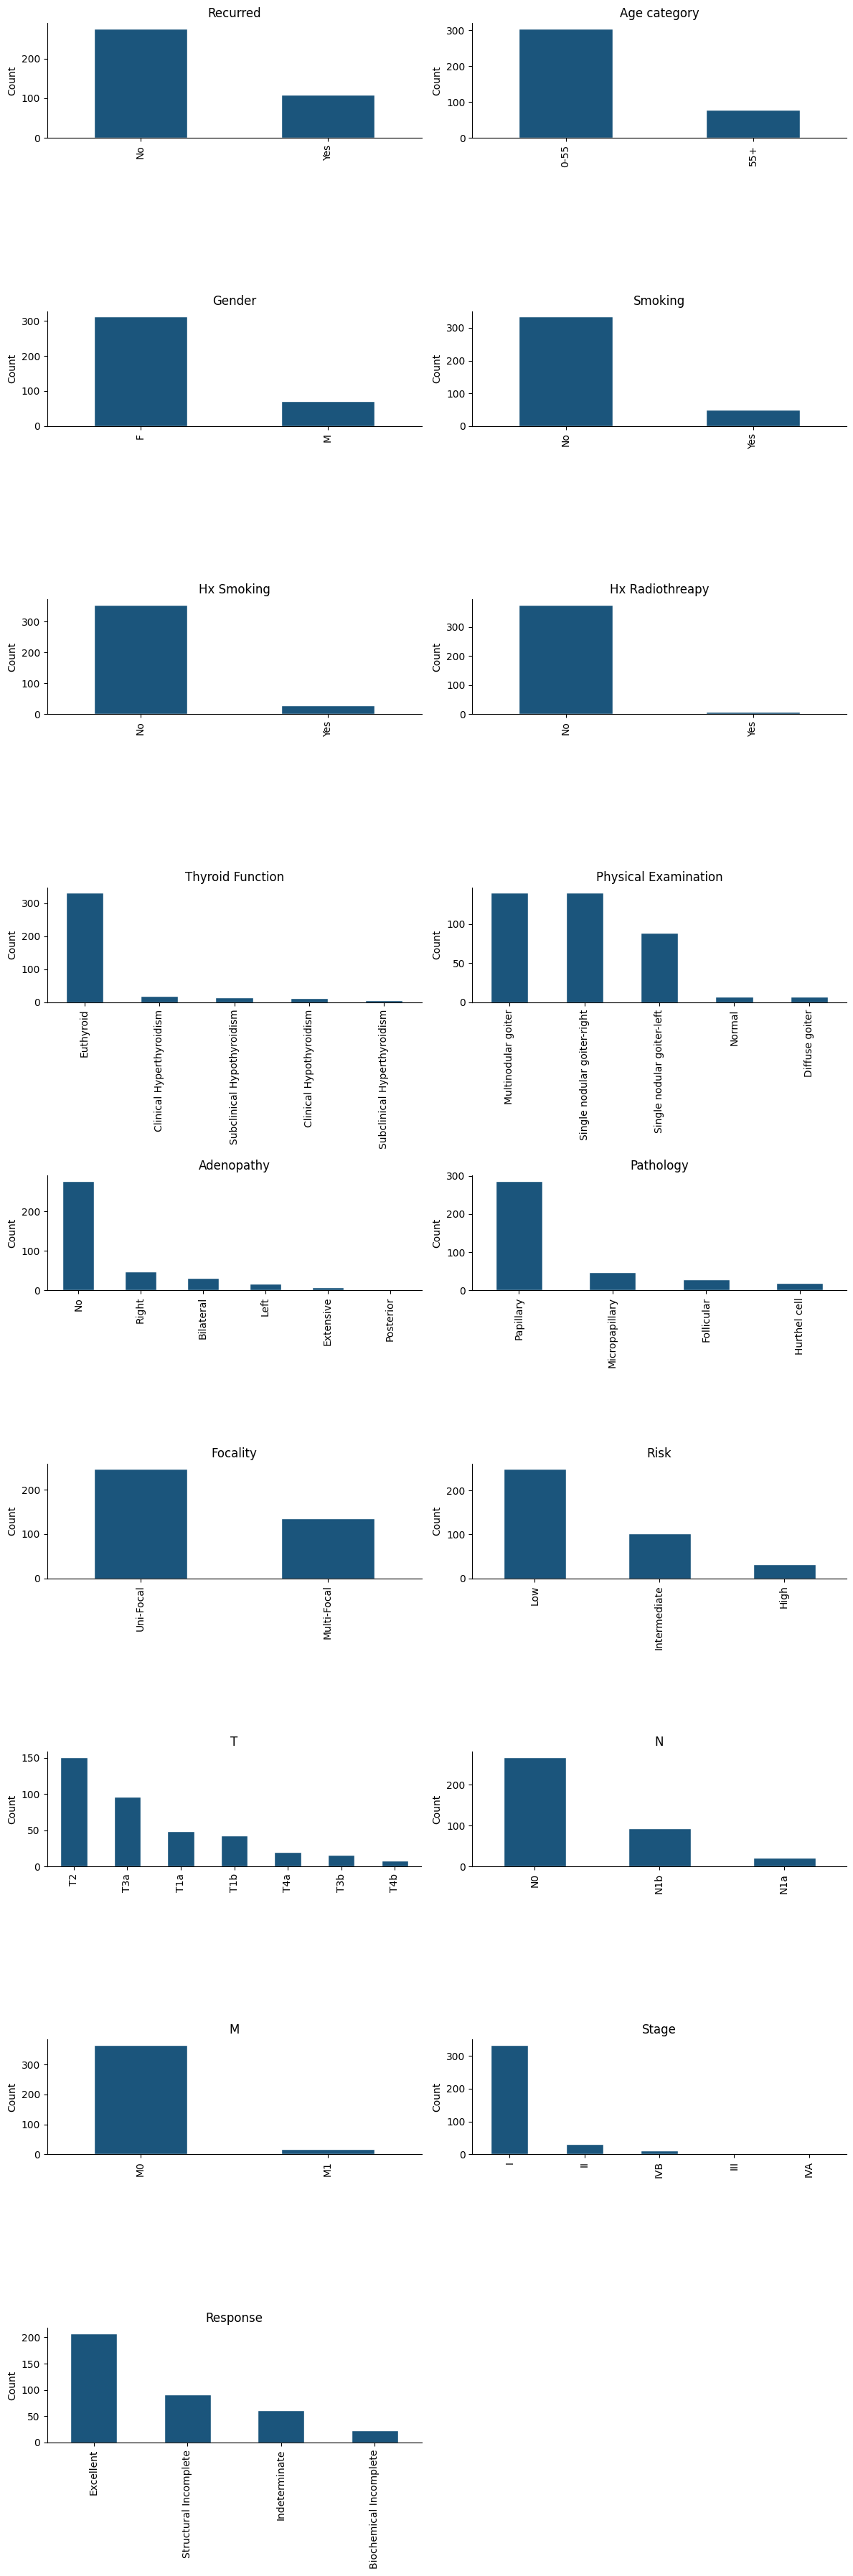

In [9]:
import matplotlib.pyplot as plt

# List of categorical variables to plot
cat_vars = [
    'Recurred', 'Age category', 'Gender', 'Smoking', 'Hx Smoking', 
    'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination',
    'Adenopathy', 'Pathology', 'Focality', 'Risk', 'T', 'N', 'M',
    'Stage', 'Response'
]

# Number of plots
n_vars = len(cat_vars)

# Create figure with 2 columns
fig, axes = plt.subplots(nrows=(n_vars + 1) // 2, ncols=2, figsize=(12, 4 * ((n_vars + 1) // 2)))
axes = axes.flatten()  # flatten for easy iteration

# Plot each categorical variable
for i, var in enumerate(cat_vars):
    tcr_raw[var].value_counts().plot(
        kind="bar",
        ax=axes[i],
        color="#1b557c",
        edgecolor="white"
    )
    axes[i].set_title(var)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)

# Hide unused subplots if odd number of vars
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<span style="font-size:14px">
We observed that the majority of individuals did not experience recurrence compared to those who did. The cohort was characterized by a higher proportion of participants younger than 55, more females, non-smokers and non-current smokers, individuals without a history of radiotherapy, those with normal thyroid function, no evidence of adenopathy, and overall a lower-risk profile

### 3.3 Assessing multicollinearity among predictors

In [35]:
mm = pd.get_dummies(tcr_raw.drop(['Age', 'Recurred'], axis=1), drop_first=True)
corr_matrix = mm.corr()

In [ ]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_masked = corr_matrix.mask(mask)

fig = px.imshow(
    corr_masked,
    text_auto=".2f",  
    color_continuous_scale=["#ebf2f6", "#aed6f1", "#3498db"],
    aspect="auto"
)

fig.update_layout(
    width=1000,
    height=900,
    font=dict(size=8, color="#1b557c"),       
    xaxis=dict(
        tickangle=-45,
        showticklabels=True,
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        showticklabels=True,
        showgrid=True,
        zeroline=False
    ),
    title="Correlation Heatmap",
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()

<span style="font-size:14px">
From this correlation matrix, we can see that there is strong correlation between for instance

- low risk (ATA) and no adenopathy with a pearson correlation coefficient of 0.68
- low risk (ATA) and response excellent with a pearson correlation coefficient of 0.60
- Stage IVB and M1 with a pearson correlation coefficient of 0.70


<span style="font-size:14px">
In the code below, we create a code to identify in the  pairwise manner, the correlation among predictors of recurrence of thyroid cancer.

In [38]:

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
filtered = corr_matrix.where(mask)

strong_corr = filtered.stack().reset_index()
strong_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']

threshold = 0.6
strong_corr = strong_corr[strong_corr['Correlation'].abs() > threshold]

strong_corr = strong_corr.reindex(strong_corr['Correlation'].abs().sort_values(ascending=False).index)

print(strong_corr)


                          Feature 1                       Feature 2  \
245      Thyroid Function_Euthyroid        Thyroid_01_non-euthyroid   
961              Response_Excellent       Response_01_not-excellent   
553                   Adenopathy_No               Adenopathy_01_yes   
392     Physical Examination_Normal              Physical_01_goiter   
897                           N_N1b               Adenopathy_01_yes   
540                   Adenopathy_No                           N_N1b   
82                      Smoking_Yes              Smoking status_Yes   
714               Risk_Intermediate                        Risk_Low   
902                            M_M1                       Stage_IVB   
532                   Adenopathy_No                        Risk_Low   
757                        Risk_Low               Adenopathy_01_yes   
744                        Risk_Low                           N_N1b   
639        Pathology_Micropapillary             Pathology_Papillary   
752   

<span style="font-size:14px">
We identify the same correlated variables such as low risk and no adenopathy, metastasis and stage IVB etc. Therefore, it is the right time to discuss about cancer classification and what is conveyed by these variables.

What is tumor staging?
Tumor staging conveys information about the size of the tumor and the extend to which it has spread in the body. It is a clinical management tool, since a localized tumor could benefit from simple resection with an appropriate follow-up,whereas metastasized tumors would require not only surgery but also adjuvant therapies such as radiation or chemotherapy among others.
Staging may differ between cancer types, but the TNM system is the most widely used. For thyroid cancer for instance, staging is based on the American Joint Committee on Cancer (AJCC) Tumor, Node, Metastasis (TNM) system.
- T describes the size of the original (primary) tumor and whether it has invaded nearby tissue,
- N describes nearby (regional) lymph nodes that are involved,
- M describes distant metastasis (spread of cancer from one part of the body to another).
So, basically, staging is some form of summarizing the information contained in T, N, and M scores, for clinical management purposes.
Similarly, an adenopathy is just a lymph node involvement (N score). Therefore, it is expected that there is a correlation between adenopathy and N score. At the physical examination, the physician will assess the size of the tumor wich is part of the T score in the TNM system.

We can already see that having the stage itself forfeits the need for T, N, M scores as well as adenopathy and physical examination.

Similarly, the ATA risk stratification is a summary of several variables including the type, differentiation, local and regional invasion an distant metastis among other.

From a machine learning perspective, algorithms vary in their sensitivity to multicollinearity. Linear and logistic regression are highly susceptible, as strong correlations among predictors can destabilize coefficient estimates and hinder interpretation. In contrast, tree-based methods such as decision trees and random forests are generally more resilient to multicollinearity. Nonetheless, even in these models, multicollinearity may still reduce the interpretability of results by obscuring the relative importance of individual features.

We will run two different sets of models, one with all variables and another excluding the correlated variables mentioned above.

At the modeling stage, we will not consider age as a continuous variable, and will also use smoking status (ever/never smoked) instead of current and past smoking history. We will use the the TNM scores instead of the aggregated stage variable and will not consider the physical examination findings, nor the adenopathy variable.
Finally, we will use the ATA risk stratification cautiously, by evaluating our models with and without this variable.

(minus Age, Smoking, Hx Smoking, Physical Exam Findings, Adenopathy, Stage)


We decide to collapse some categories for the logistic regression analysis.

In [39]:
# Smoking status: Yes vs. No
tcr_raw['Smoking status'] = tcr_raw.apply(
    lambda row: "Yes" 
                if (row['Smoking'] == "Yes" or row['Hx Smoking'] == "Yes") 
                else "No",
    axis=1
)

# Thyroid function: Euthyroid vs. Else
tcr_raw['Thyroid_01'] = (
    tcr_raw['Thyroid Function']
    .astype(str).str.strip().str.lower()
    .map(lambda x: 'euthyroid' if x == 'euthyroid' else 'non-euthyroid')
)

# Physical Examination: Normal vs. Else
tcr_raw['Physical_01'] = (
    tcr_raw['Physical Examination']
    .astype(str).str.strip().str.lower()
    .map(lambda x: 'Normal' if x == 'normal' else 'goiter')
    )

# Adenopathy: Yes vs. No
tcr_raw['Adenopathy_01'] = (
    tcr_raw['Adenopathy']
    .astype(str).str.strip().str.lower()
    .map(lambda x: 'No' if x == 'no' else 'yes')
    )

# Response: Excellent vs. Else
tcr_raw['Response_01'] = (
    tcr_raw['Response']
    .astype(str).str.strip().str.lower()
    .map(lambda x:  'excellent' if x == 'excellent' else 'not-excellent')
)

#### 3.4 Distribution of features by recurrence status

In [41]:
columns = ['Age', 'Age category', 'Gender', 'Smoking status',
           'Smoking', 'Hx Smoking', 'Thyroid Function','Thyroid_01', 
           'Physical Examination', 'Physical_01', 'Adenopathy', 'Adenopathy_01',        
           'Hx Radiothreapy', 'Pathology', 'Focality', 
           'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Response_01']

categorical = ['Age category', 'Gender', 'Smoking status',
           'Smoking', 'Hx Smoking', 'Thyroid Function','Thyroid_01', 
           'Physical Examination', 'Physical_01', 'Adenopathy', 'Adenopathy_01',        
           'Hx Radiothreapy', 'Pathology', 'Focality', 
           'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Response_01']
table1 = TableOne(data=tcr_raw, columns=columns, categorical=categorical,
                  groupby='Recurred', pval=True)
print(table1) 

                                                        Grouped by Recurred                                               
                                                                    Missing      Overall           No          Yes P-Value
n                                                                                    383          275          108        
Age, mean (SD)                                                            0  40.9 (15.1)  38.4 (12.9)  47.1 (18.3)  <0.001
Age category, n (%)         0-55                                              305 (79.6)   240 (87.3)    65 (60.2)  <0.001
                            55+                                                78 (20.4)    35 (12.7)    43 (39.8)        
Gender, n (%)               F                                                 312 (81.5)   246 (89.5)    66 (61.1)  <0.001
                            M                                                  71 (18.5)    29 (10.5)    42 (38.9)        
Smoking status, 

<span style=font-size:14px>
As expected, compared to individuals without recurrence, those with recurrence were more likely to be older (39.8% aged over 55 years versus 12.7%), to have a current or past history of smoking (34.3% versus 10.2%), and to present with more advanced cancer stages (stage II or higher). Nearly all individuals with recurrence had a non-excellent response to initial treatment (99.1% versus 24.7%).

### 4. Modeling

### 4.1 Problem statement

<span style=font-size:14px>
In traditional statistical research, we would explore the relationship between one or more predictors and a response variable, sometimes from a causal perspective. This implies formulating a research question and proceeding with the hypothesis testing. In this particular project, we could hypothesize that:

- Null hypothesis: patients who had recurrence of thyroid cancer do not differ from those who did not have recurrence with respect to the predictors in the dataset.
- Alternative hypothesis: patients who had recurrence of thyroid cancer differ from those who did not have recurrence with respect to the predictors in the dataset.

Note that we would use the whole dataset and produce parameter estimates and p-values. We will evaluate how good our model fits the data at hand, and identify the signigicance of the association between each predictor and the outcome of interest, recurrence in this case. For instance, we may find that people who smoke or had a history of smoking, have higher odds of recurrence compared to people who never smoked. However, we with, this approach we would not be able to make predictions on new data.

In machine learning however, we are more interested in making predictions on new data. Similarly, we need to define the problem, with in this case, is a classification problem. We need to assess how well a model, givent the set of predictors, can predict recurrence in a new patient. This requires us to split the data into a training set and a test set. The training set will be used to train the model, and the test set will be used to evaluate the model's performance on unseen data. We will use various classification algorithms to build models that can predict recurrence based on the predictors in the dataset. We will evaluate the models using metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

We first run a logistic regression model from a statistical perspective, then we will proceed with the machine learning approach.

### 4.1 Statistical logistic regression

<span style=font-size:14px>
As mentioned earlier, we exclude some variables from the model to avoid multicollinearity. We will consider smoking status (ever/never smoked), as our exposure of insterest, and hypothesize that people who ever smoked have higher odds of recurrence compared to people who never smoked, adjusting for other predictors. 

We will run several models with different sets of predictors. As shown in Table 1, several predictors exhibit sparse or highly imbalanced categories that create quasi-complete or perfect separation, such as Response (with “Excellent” almost always non-recurrent and “Structural Incomplete” almost always recurrent), advanced T stages (T4b exclusively recurrent, T4a and T3b heavily skewed), and M stage (M1 always recurrent), all of which can lead to convergence issues in logistic regression. The observation is true for Stage where all stages higher or equal to stage III recurred. We will therefore exclude these variables from our models.

In [ ]:
# Formatting for logistic regression
tcr_log0 = tcr_raw.copy()
tcr_log0['Recurred_01'] = (
    tcr_log0['Recurred']
    .astype(str).str.strip().str.lower()
    .map({'yes': 1, 'no': 0})
)

tcr_log1 = tcr_log0.rename(columns={
    "Age category": "Age_category",
    "Smoking status": "Smoking_status",
    "Hx Radiothreapy": "Hx_Radiotherapy",
    "Physical Examination": "Physical_Examination"  
})

tcr_log = tcr_log1.drop(columns=['Age', 'Smoking', 'Hx Smoking', 'Thyroid Function', 'Response', 
                                 'Response_01', 'T', 'N', 'M', 'Stage', 'Adenopathy', 'Physical_Examination','Recurred'])

<span style=font-size:14px>

- Model 1: recurrence as a function of smoking status, controlled for age category, gender, thyroid function , physical examination, and adenopathy.
  

In [84]:
formula1 = (
    "Recurred_01 ~ C(Smoking_status) + C(Age_category) + C(Gender) + " 
    "C(Thyroid_01) + C(Physical_01) + C(Adenopathy_01)"     
)

log_model1 = smf.logit(formula=formula1, data=tcr_log).fit()
log_model1.summary()

Optimization terminated successfully.
         Current function value: 0.333272
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Recurred_01   No. Observations:                  383
Model:                          Logit   Df Residuals:                      376
Method:                           MLE   Df Model:                            6
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:                  0.4397
Time:                        14:16:35   Log-Likelihood:                -127.64
converged:                       True   LL-Null:                       -227.82
Covariance Type:            nonrobust   LLR p-value:                 1.603e-40
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -2.9683      1.046     -2.838      0.005      -5.019      -0.918
C(Smoking_status)[T.Yes]           0.4575      0.469      0.976      0.329      -0.461       1.376
C(Age_category)[T.55+]             2.1764      0.395      5.504      0.000       1.401       2.951
C(Gender)[T.M]                     1.2879      0.445      2.893      0.004       0.415       2.160
C(Thyroid_01)[T.non-euthyroid]    -1.0598      0.539     -1.967      0.049      -2.116      -0.004
C(Physical_01)[T.goiter]          -0.0811      1.022     -0.079      0.937      -2.083       1.921
C(Adenopathy_01)[T.yes]            3.4484      0.363      9.511      0.000       2.738       4.159
==================================================================================================
"""

<span style=font-size:14px>
Model fit:

- Pseudo R-squared (McFadden’s R²) = 0.4397 → The predictors account for a ~44% improvement in model fit over an intercept-only model, based on McFadden’s pseudo R².

- Log-Likelihood (LL) = -127.64 vs LL-Null = -227.82 → The fitted model improves the log-likelihood considerably over a null model (intercept-only).

- Likelihood Ratio (LR) test p-value = 1.6 × 10⁻⁴⁰ → Extremely significant, confirming that the model as a whole fits the data much better than a null model.

In [85]:
params = log_model1.params
conf = log_model1.conf_int()

conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']

conf['p-value'] = log_model1.pvalues

results = conf.copy()
results[['2.5%', '97.5%', 'OR']] = np.exp(results[['2.5%', '97.5%', 'OR']])

print(results.round(3))


                                  2.5%   97.5%      OR  p-value
Intercept                        0.007   0.399   0.051    0.005
C(Smoking_status)[T.Yes]         0.630   3.961   1.580    0.329
C(Age_category)[T.55+]           4.061  19.132   8.814    0.000
C(Gender)[T.M]                   1.515   8.674   3.625    0.004
C(Thyroid_01)[T.non-euthyroid]   0.121   0.996   0.347    0.049
C(Physical_01)[T.goiter]         0.125   6.829   0.922    0.937
C(Adenopathy_01)[T.yes]         15.452  64.009  31.449    0.000


<span style="font-size:14px">

In this adjusted model, having a positive smoking history (ever smoked) was not associated with higher odds of thyroid cancer recurrence compared to never smokers (p = 0.329), after adjusting for other factors. This finding is consistent with the current literature, which has not established smoking as a significant risk factor for thyroid cancer or its recurrence[^1]. To the contrary, some studies have reported an inverse relationship between smoking and thyroid cancer, although such conclusions should be interpreted with caution[^2].  

We also noted separation issues with some variables, such as adenopathy and, to a lesser extent, age category. Therefore, adenopathy will not be included in subsequent models.  

[^1]: Jiang H, Li Yi, Shen J, et al. *Cigarette smoking and thyroid cancer risk: A Mendelian randomization study*. Cancer Med. 2023;12:19866–19873. doi:10.1002/cam4.6570  
[^2]: Lee JH, Chai YJ, Yi KH. *Effect of cigarette smoking on thyroid cancer: Meta-analysis*. Endocrinol Metab (Seoul). 2021 Jun;36(3):590–598. doi:10.3803/EnM.2021.954. PMID: 34034364; PMCID: PMC8258339.  
</span>


<span style=font-size:14px>

- Model 2: recurrence as a function of smoking status, controlled for age category, gender, thyroid function , physical examination, and history of radiotherapy.


In [99]:
formula2 = (
    "Recurred_01 ~ C(Smoking_status) + C(Age_category) + C(Gender) + " 
    "C(Thyroid_01) + C(Physical_01) + C(Adenopathy_01) + C(Hx_Radiotherapy)"   
)

log_model2 = smf.logit(formula=formula2, data=tcr_log).fit()
log_model2.summary()

Optimization terminated successfully.
         Current function value: 0.331113
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Recurred_01   No. Observations:                  383
Model:                          Logit   Df Residuals:                      375
Method:                           MLE   Df Model:                            7
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:                  0.4433
Time:                        14:29:25   Log-Likelihood:                -126.82
converged:                       True   LL-Null:                       -227.82
Covariance Type:            nonrobust   LLR p-value:                 4.333e-40
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -2.9440      1.052     -2.799      0.005      -5.005      -0.883
C(Smoking_status)[T.Yes]           0.3235      0.481      0.672      0.501      -0.620       1.267
C(Age_category)[T.55+]             2.1462      0.397      5.401      0.000       1.367       2.925
C(Gender)[T.M]                     1.2679      0.447      2.839      0.005       0.392       2.143
C(Thyroid_01)[T.non-euthyroid]    -1.1413      0.556     -2.051      0.040      -2.232      -0.051
C(Physical_01)[T.goiter]          -0.0914      1.028     -0.089      0.929      -2.105       1.923
C(Adenopathy_01)[T.yes]            3.4588      0.363      9.532      0.000       2.748       4.170
C(Hx_Radiotherapy)[T.Yes]          1.8596      1.530      1.216      0.224      -1.139       4.858
==================================================================================================
"""

<span style=font-size:14px>
Model fit:
adding focality did not improve the model fit compared to model 1 (with 0.4433 and LLR of -126.82).

In [91]:
params = log_model2.params
conf = log_model2.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']

conf['p-value'] = log_model2.pvalues

results = conf.copy()
results[['2.5%', '97.5%', 'OR']] = np.exp(results[['2.5%', '97.5%', 'OR']])

print(results.round(3))

                                  2.5%    97.5%      OR  p-value
Intercept                        0.007    0.414   0.053    0.005
C(Smoking_status)[T.Yes]         0.538    3.549   1.382    0.501
C(Age_category)[T.55+]           3.925   18.635   8.552    0.000
C(Gender)[T.M]                   1.481    8.528   3.553    0.005
C(Thyroid_01)[T.non-euthyroid]   0.107    0.951   0.319    0.040
C(Physical_01)[T.goiter]         0.122    6.838   0.913    0.929
C(Adenopathy_01)[T.yes]         15.605   64.720  31.780    0.000
C(Hx_Radiotherapy)[T.Yes]        0.320  128.772   6.421    0.224


<span style="font-size:14px">

We still don't find a significant association between ever smoking and thyroid cancer recurrence, adjusting for the other selected predictors. 

<span style=font-size:14px>

- Model 3: recurrence as a function of smoking status, controlled for age category, gender, thyroid function , physical examination, history of radiotherapy, focality and pathology.

In [98]:
formula3 = (
    "Recurred_01 ~ C(Smoking_status) + C(Age_category) + C(Gender) + " 
    "C(Thyroid_01) + C(Physical_01) + C(Adenopathy_01) + C(Hx_Radiotherapy) + C(Focality) + " 
    "C(Pathology)"   
)

log_model3 = smf.logit(formula=formula3, data=tcr_log).fit()
log_model3.summary()

Optimization terminated successfully.
         Current function value: 0.299998
         Iterations 31


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Recurred_01   No. Observations:                  383
Model:                          Logit   Df Residuals:                      371
Method:                           MLE   Df Model:                           11
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:                  0.4956
Time:                        14:28:31   Log-Likelihood:                -114.90
converged:                       True   LL-Null:                       -227.82
Covariance Type:            nonrobust   LLR p-value:                 3.142e-42
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.0079      1.195     -0.843      0.399      -3.350       1.335
C(Smoking_status)[T.Yes]           0.0850      0.557      0.153      0.879      -1.006       1.176
C(Age_category)[T.55+]             2.0306      0.434      4.679      0.000       1.180       2.881
C(Gender)[T.M]                     1.3459      0.477      2.822      0.005       0.411       2.281
C(Thyroid_01)[T.non-euthyroid]    -1.2482      0.591     -2.112      0.035      -2.407      -0.090
C(Physical_01)[T.goiter]           0.0496      1.081      0.046      0.963      -2.068       2.167
C(Adenopathy_01)[T.yes]            3.2516      0.395      8.233      0.000       2.478       4.026
C(Hx_Radiotherapy)[T.Yes]          1.3583      1.998      0.680      0.497      -2.557       5.273
C(Focality)[T.Uni-Focal]          -0.8487      0.350     -2.422      0.015      -1.535      -0.162
C(Pathology)[T.Hurthel cell]      -2.0827      0.841     -2.475      0.013      -3.732      -0.434
C(Pathology)[T.Micropapillary]   -46.4113   2.55e+09  -1.82e-08      1.000   -4.99e+09    4.99e+09
C(Pathology)[T.Papillary]         -1.3979      0.573     -2.441      0.015      -2.520      -0.275
==================================================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [95]:
params = log_model3.params
conf = log_model3.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']

conf['p-value'] = log_model3.pvalues

results = conf.copy()
results[['2.5%', '97.5%', 'OR']] = np.exp(results[['2.5%', '97.5%', 'OR']])

print(results.round(3))

                                  2.5%    97.5%      OR  p-value
Intercept                        0.035    3.798   0.365    0.399
C(Smoking_status)[T.Yes]         0.366    3.243   1.089    0.879
C(Age_category)[T.55+]           3.254   17.836   7.618    0.000
C(Gender)[T.M]                   1.508    9.783   3.841    0.005
C(Thyroid_01)[T.non-euthyroid]   0.090    0.914   0.287    0.035
C(Physical_01)[T.goiter]         0.126    8.736   1.051    0.963
C(Adenopathy_01)[T.yes]         11.912   56.020  25.833    0.000
C(Hx_Radiotherapy)[T.Yes]        0.078  195.077   3.890    0.497
C(Focality)[T.Uni-Focal]         0.215    0.850   0.428    0.015
C(Pathology)[T.Hurthel cell]     0.024    0.648   0.125    0.013
C(Pathology)[T.Micropapillary]   0.000      inf   0.000    1.000
C(Pathology)[T.Papillary]        0.080    0.759   0.247    0.015


<span style=font-size:14px>
Still no significant association between ever smoking and thyroid cancer recurrence, adjusting for the other selected predictors.

In [100]:
models = {
    "Model 1": log_model1,
    "Model 2": log_model2,
    "Model 3": log_model3
}

summary_data = []

for name, model in models.items():
    # number of predictors = Df Model
    df_model = int(model.df_model)
    # number of estimated parameters (predictors + intercept)
    k = int(df_model + 1)
    # log-likelihood
    ll = model.llf
    # pseudo R²
    pseudo_r2 = model.prsquared
    # AIC and BIC (available directly)
    aic = model.aic
    bic = model.bic
    
    summary_data.append([name, df_model, ll, pseudo_r2, aic, bic])

# Create DataFrame
summary_table = pd.DataFrame(summary_data, 
                             columns=["Model", "Predictors", "Log-Likelihood", 
                                      "Pseudo R² (McFadden)", "AIC", "BIC"])

print(summary_table.round(3))


     Model  Predictors  Log-Likelihood  Pseudo R² (McFadden)      AIC      BIC
0  Model 1           6        -127.643                 0.440  269.286  296.922
1  Model 2           7        -126.816                 0.443  269.633  301.217
2  Model 3          11        -114.899                 0.496  253.798  301.175


<span style=font-size:14px>

In conclusion:

Model 1 is the most parsimonious, with 6 predictors, a Pseudo R² of 0.44, and the lowest BIC (296.9). This suggests it balances fit and simplicity well.

Model 2 adds one more predictor but provides only a negligible improvement in fit (Pseudo R² 0.443, LL –126.8). Its AIC and BIC are worse than Model 1, so it does not justify the extra complexity.

Model 3 includes 11 predictors and shows the best overall fit (highest Pseudo R² = 0.496, lowest AIC = 253.8). However, its BIC (301.2) is higher than Model 1, reflecting a greater penalty for complexity.

Regardless of the model, smoking status is not significantly associated with recurrence after adjusting for other factors.

#### 4. Machine learning classification algorithms

##### 4.1 All variables

a. Shared Preprocessing Setup

In [101]:
tcr_ml = tcr_raw
tcr_ml.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred',
       'Age category', 'Smoking status', 'Thyroid_01', 'Physical_01',
       'Adenopathy_01', 'Response_01'],
      dtype='object')

In [102]:
# Features and target
feature_cols = ['Age category', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
                'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
                'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']

X = tcr_ml[feature_cols]
y = tcr_ml['Recurred']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=0,
    stratify=y # preserve class balance
    )

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)


- Distribution of features by recurrence status in the training set

In [106]:
# Combine predictors with outcome
train_df = pd.concat([X_train, y_train.rename("Recurred")], axis=1)

# All variables in X_train
columns = [
    'Age category', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

# Categorical variables (adjust as needed for your dataset)
categorical = [
    'Age category', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

# Generate Table 1
table_train = TableOne(data=train_df,
                  columns=columns,
                  categorical=categorical,
                  groupby='Recurred',
                  pval=True)

print(table_train)



                                                        Grouped by Recurred                                            
                                                                    Missing     Overall           No        Yes P-Value
n                                                                                   287          206         81        
Age category, n (%)         0-55                                             229 (79.8)   180 (87.4)  49 (60.5)  <0.001
                            55+                                               58 (20.2)    26 (12.6)  32 (39.5)        
Gender, n (%)               F                                                234 (81.5)   184 (89.3)  50 (61.7)  <0.001
                            M                                                 53 (18.5)    22 (10.7)  31 (38.3)        
Hx Smoking, n (%)           No                                               266 (92.7)   195 (94.7)  71 (87.7)   0.072
                            Yes         


- Distribution of features by recurrence status in the test set

In [107]:
# Combine predictors with outcome
test_df = pd.concat([X_test, y_test.rename("Recurred")], axis=1)

# Variables (same as in training set)
columns = [
    'Age category', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

# Define which are categorical (adjust if some are numeric)
categorical = [
    'Age category', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

# Generate Table 1 for the test set
table1_test = TableOne(data=test_df,
                       columns=columns,
                       categorical=categorical,
                       groupby='Recurred',
                       pval=True)

print(table1_test)


                                                        Grouped by Recurred                                          
                                                                    Missing    Overall          No        Yes P-Value
n                                                                                   96          69         27        
Age category, n (%)         0-55                                             76 (79.2)   60 (87.0)  16 (59.3)   0.006
                            55+                                              20 (20.8)    9 (13.0)  11 (40.7)        
Gender, n (%)               F                                                78 (81.2)   62 (89.9)  16 (59.3)   0.002
                            M                                                18 (18.8)    7 (10.1)  11 (40.7)        
Hx Smoking, n (%)           No                                               89 (92.7)   66 (95.7)  23 (85.2)   0.095
                            Yes                         

In [112]:
# Add split indicator to each set
train_df = X_train.copy()
train_df["Split"] = "TrainSet"

test_df = X_test.copy()
test_df["Split"] = "TestSet"

# Combine back into one dataset
split_df = pd.concat([train_df, test_df], axis=0)

# Define columns
columns = [
    'Age category', 'Gender', 'Hx Smoking', 'Hx Radiothreapy',
    'Thyroid Function', 'Physical Examination', 'Adenopathy',
    'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response'
]

categorical = columns  # adjust if some are numeric

# Build Table 1 by split
from tableone import TableOne
table_split = TableOne(data=split_df,
                       columns=columns,
                       categorical=categorical,
                       groupby='Split',
                       pval=True)

print(table_split)


                                                        Grouped by Split                                           
                                                                 Missing     Overall    TestSet    TrainSet P-Value
n                                                                                383         96         287        
Age category, n (%)         0-55                                          305 (79.6)  76 (79.2)  229 (79.8)   1.000
                            55+                                            78 (20.4)  20 (20.8)   58 (20.2)        
Gender, n (%)               F                                             312 (81.5)  78 (81.2)  234 (81.5)   1.000
                            M                                              71 (18.5)  18 (18.8)   53 (18.5)        
Hx Smoking, n (%)           No                                            355 (92.7)  89 (92.7)  266 (92.7)   1.000
                            Yes                                         

a. Pipeline for data preprocessing and model training 

In [114]:
# Logistic regression
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))  # Increase max_iter if needed
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # You can tune this
])
knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

# SVM
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', probability=True))  # 'linear' and 'rbf' are common choices
])
svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

# Decision Trees
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=0))
])
tree_pipeline.fit(X_train, y_train)
y_pred_tree = tree_pipeline.predict(X_test)

# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=0))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# ANN
ann_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=0))
])
ann_pipeline.fit(X_train, y_train)
y_pred_ann = ann_pipeline.predict(X_test)

- Results

In [115]:
def evaluate_model(y_true, y_pred, y_prob, model_name, pos_label='Yes'):
    cm = confusion_matrix(y_true, y_pred, labels=['No', 'Yes'])
    tn, fp, fn, tp = cm.ravel()

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, pos_label=pos_label),
        "Recall (Sensitivity)": recall_score(y_true, y_pred, pos_label=pos_label),
        "F1 Score": f1_score(y_true, y_pred, pos_label=pos_label),
        "AUC": roc_auc_score(y_true.map({'No': 0, 'Yes': 1}), y_prob),
        "Confusion Matrix": f"[[{tn}, {fp}], [{fn}, {tp}]]"
    }


In [116]:
results = []

# Logistic Regression
y_prob = clf.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred, y_prob, "Logistic Regression"))

# KNN
y_prob_knn = knn_pipeline.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred_knn, y_prob_knn, "KNN"))

# SVM
y_prob_svm = svm_pipeline.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred_svm, y_prob_svm, "SVM"))

# Decision Tree
y_prob_tree = tree_pipeline.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred_tree, y_prob_tree, "Decision Tree"))

# Random Forest
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest"))

# ANN
y_prob_ann = ann_pipeline.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred_ann, y_prob_ann, "ANN"))


In [117]:
summary_df = pd.DataFrame(results)
summary_df = summary_df.set_index("Model")
summary_df = summary_df.round(3)  # round numeric values

display(HTML(summary_df.to_html(index=True, border=0)))

,Accuracy,Precision,Recall (Sensitivity),F1 Score,AUC,Confusion Matrix
Model,,,,,,
Logistic Regression,0.969,1.000,0.889,0.941,0.992,"[[69, 0], [3, 24]]"
KNN,0.927,0.857,0.889,0.873,0.980,"[[65, 4], [3, 24]]"
SVM,0.969,1.000,0.889,0.941,0.989,"[[69, 0], [3, 24]]"
Decision Tree,0.958,0.960,0.889,0.923,0.937,"[[68, 1], [3, 24]]"
Random Forest,0.948,0.923,0.889,0.906,0.991,"[[67, 2], [3, 24]]"
ANN,0.969,1.000,0.889,0.941,0.990,"[[69, 0], [3, 24]]"


In [31]:
models = [
    ("Logistic Regression", clf, y_pred, clf.predict_proba(X_test)[:, 1]),
    ("KNN", knn_pipeline, y_pred_knn, knn_pipeline.predict_proba(X_test)[:, 1]),
    ("SVM", svm_pipeline, y_pred_svm, svm_pipeline.predict_proba(X_test)[:, 1]),
    ("Decision Tree", tree_pipeline, y_pred_tree, tree_pipeline.predict_proba(X_test)[:, 1]),
    ("Random Forest", rf_pipeline, y_pred_rf, rf_pipeline.predict_proba(X_test)[:, 1]),
    ("ANN", ann_pipeline, y_pred_ann, ann_pipeline.predict_proba(X_test)[:, 1])
]


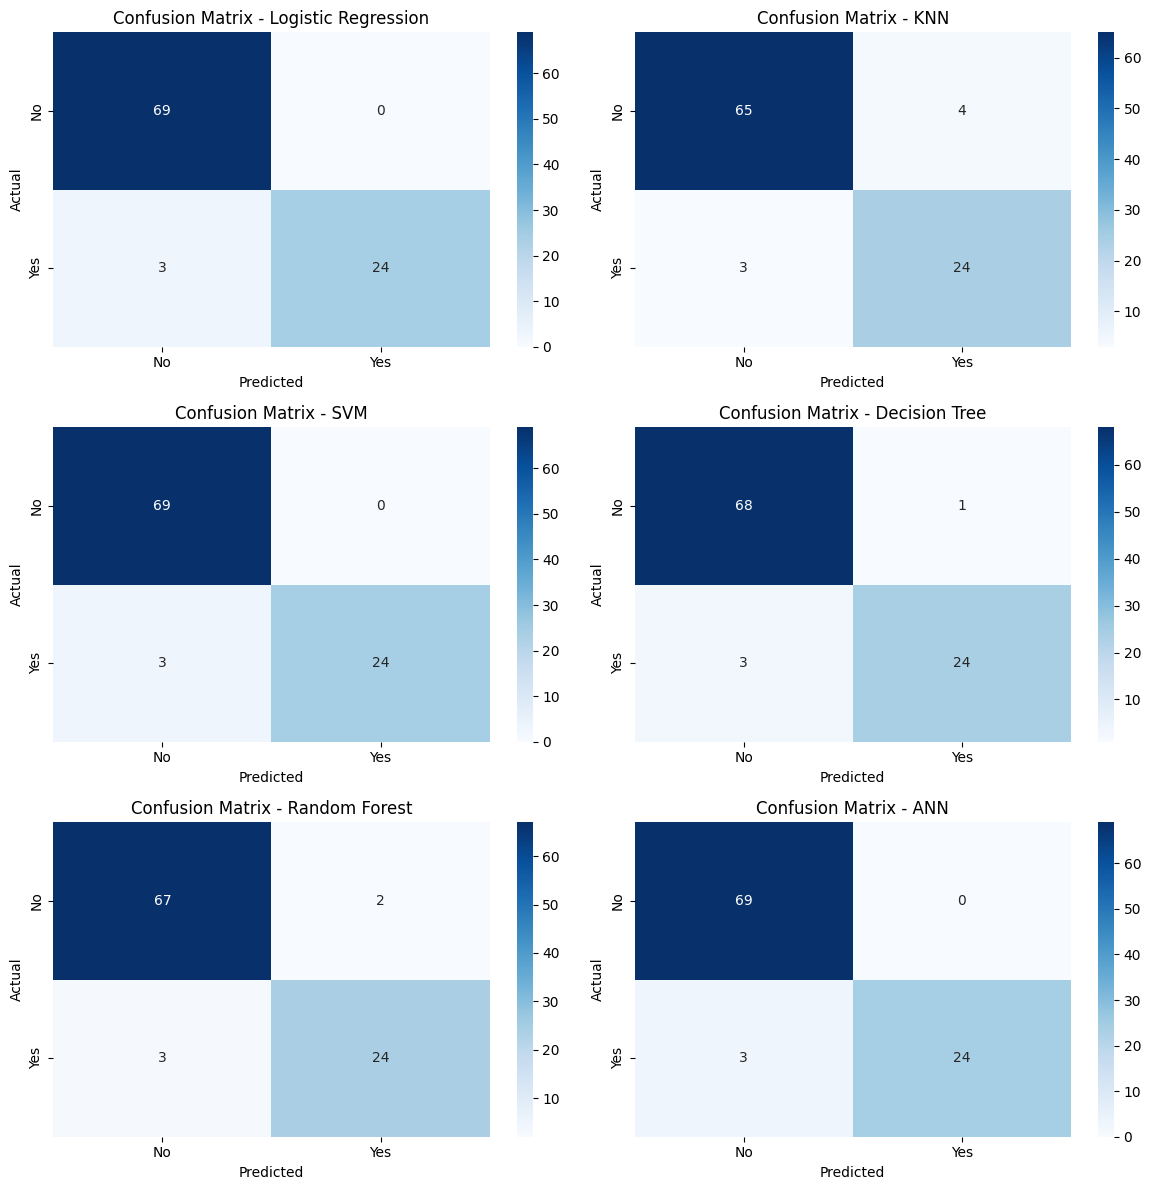

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, (name, _, y_pred, _) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
                ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

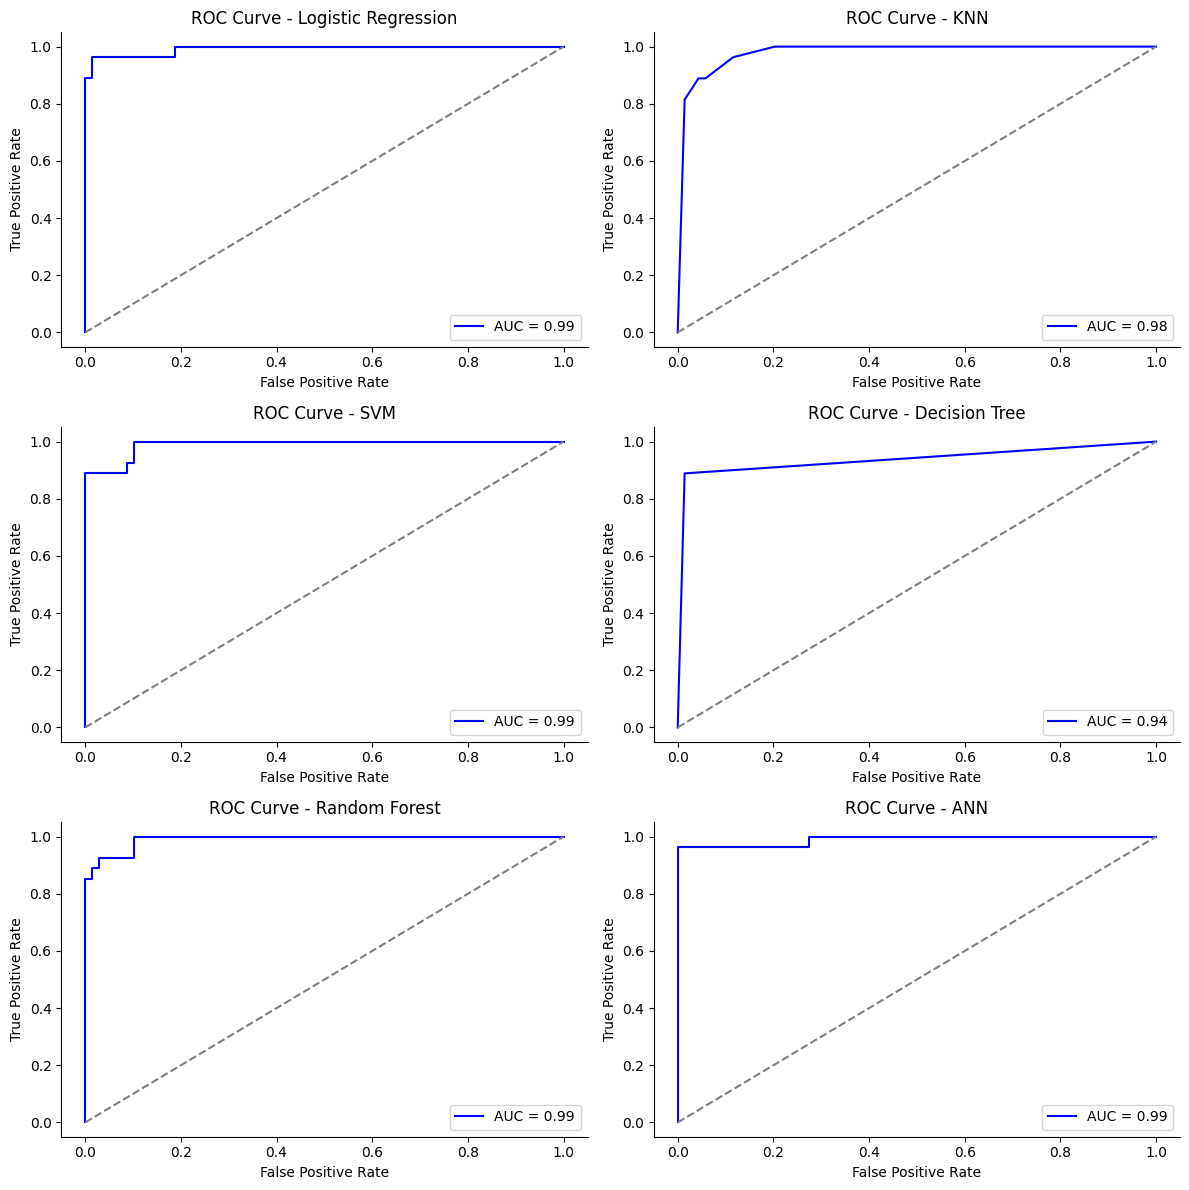

In [33]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix
)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, (name, _, _, y_prob) in enumerate(models):
    fpr, tpr, _ = roc_curve(y_test.map({'No': 0, 'Yes': 1}), y_prob)
    roc_auc = auc(fpr, tpr)
    axes[i].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[i].set_title(f'ROC Curve - {name}')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend(loc="lower right")
sns.despine()
plt.tight_layout()
plt.show()


Resources
</span>

<span style=font-size:14px>
Finally I would like to provide some resources that I found useful in this project and would benefit both the beginner and the experienced data scientist as a refresher.

- Statquest by Josh Starmer: https://www.youtube.com/@statquest. Josh has the gift of breaking down complex and esoteric concepts into bite-sized pieces digestible by the layman. You can also support him by purchasing his books "The StatQuest Illustrated Guide to MachineLearning!!!".
- The Python Data Science Handbook by Jake VanderPlas, available free online at https://jakevdp.github.io/PythonDataScienceHandbook/. This is a comprehensive guide to the Python data science ecosystem, including NumPy, Pandas, Matplotlib, Scikit-Learn, and more. However, it may need a little bit of background knowledge on python programming for eas of understanding.
- The scikit-learn official website https://scikit-learn.org/stable/index.html